Volatility Clustering and GARCH 
Using S&P 500 Stock Data

Stocks and financial time series have familiar jagged edges that crest and fall suddenly, this is in part the result of volatility clustering and part of what makes financial time series difficult to forecast. We will cover heteroskedasticity, volatility clustering, and apply the GARCH model to forecast the variance of our time series.

In [1]:
!pip install pandas numpy matplotlib scipy statsmodels arch



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import random
import itertools
from arch import arch_model
from scipy.stats import shapiro
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
%matplotlib inline

,TJX,DXC,K,MA,PNC,FCX,MDT,NCLH
date,,,,,,,,
2013-02-08,45.68,NaN,58.91,52.447,63.35,35.64,47.10,27.91
2013-02-11,45.40,NaN,59.12,52.085,64.00,35.33,47.22,27.68
2013-02-12,45.20,NaN,59.25,51.964,64.77,35.67,47.11,28.32
2013-02-13,45.01,NaN,59.29,51.921,64.17,35.64,46.99,28.92
2013-02-14,45.21,NaN,59.58,52.216,63.87,35.53,47.17,29.25


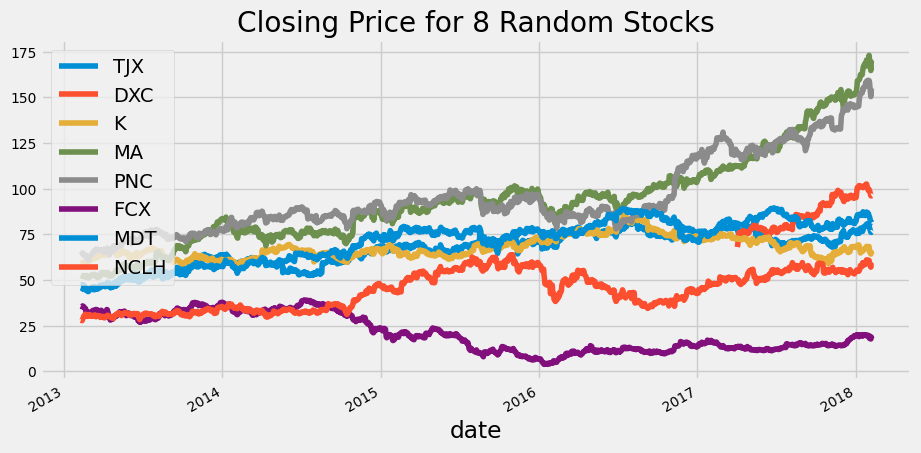

In [3]:
path = r"C:\Users\Acer\Downloads\S&P500StockData\individual_stocks_5yr\individual_stocks_5yr"
csvs = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]

df = pd.DataFrame()
for file in random.sample(range(1, len(csvs)), 8):
    stock_df = pd.read_csv(csvs[file])
    stock_df.index = pd.DatetimeIndex(stock_df.date)
    name = stock_df['Name'].iloc[0]
    df[name] = stock_df['close']

df.plot(figsize=(10, 5), title='Closing Price for 8 Random Stocks')
df.head()

Heteroskedasticity

Think about an idealized time series as a set of observations chosen independently and from identical distributions. Understanding this series is as easy as estimating the parameters of the distribution. This is the idea behind stationarity. Once a time series is stationary, we can learn the parameters of the distirbution and forecast, but rarely is it that easy. This project is about time series that exhibit heteroskedasticity, specifically conditional heteroskedasticity and the models we use to forecast them.

If we return to the idealized time series, heteroskedasticity is when the variance of the underlying distribution used to construct our time series changes as a function of time. A common appearance of heterskedasticity is a time series whose variance increases with time, growing outward in a conal pattern. Small amounts of heteroskedasticity can sometimes be masked by a Box-Cox transformation, which makes the data distribution more normal. In our forecasts of the S&P500, not only are our changes in variance too great to mask but the variance at each step is conditional on the variance of past time steps. 
This is called conditional heteroskedasticity or volatility clustering.

Volatility Clustering

Volatility clustering is the behavior behind the familiar jagged peaks of financial time series. When we look at the plot above we can see there are periods of high and low volatility. Periods where a positive feedback loop forms and changes in variance give rise to greater changes in variance punctuated by periods of relative calm. The ARCH and GARCH models are designed to model the variance for volatile time series. Note, these models do not forecast estimated values. The ARCH and GARCH models specifically capture the expected variance of the residuals from another model. To forecast financial markets we would use ARCH and GARCH after applying another model like ARIMA first.

Autoregressive Conditional Heteroskedasticity (ARCH)

If you're familiar with autoregressive (AR) models, ARCH is easy to understand. In an AR model the current value is dependent on p previous timesteps where p lagged values were highly correlated with the current timestep. With ARCH, the variance of the current time step is dependent on p lagged squared standard error terms, with coefficients α. The standard error is the difference between the observed and predicted value from another model.

If the volatility tends to cluster then recent large squared errors are likely to lead to large variance, and more large squared errors. Like fitting an AR model we can look at PACF and ACF plots to see where our series is autocorrelated and use that to choose a value for our parameter, p. If we have an ARCH(1) or a first order ARCH model we assume the series is stationary except for the change in variance. We often use ARCH models in conjunction with another AR or ARMA model where we would pass the ARCH model the squared residuals from the ARMA model. We can also pass ARCH a mean process, as in the case of this where we will pass the percent changes in stock closing value- which is a series that will hover around 0.

Generalized Autoregressive Conditional Heteroskedasticity (GARCH)

GARCH extends ARCH by allowing the variance to depend on its own lags and the lags of the squared residuals. GARCH can capture greater changes like increasing and decreasing volatility.

We have two parameters for GARCH(q, p):

q: Number of lag variances
p: Number of lag residual errors

The parameters we're using here are consistent with the ARCH python library but more often the swapped notation is used.

GARCH often fits data better than ARCH when there's heteroskedasticity and volatility clustering. We will perform an analysis with both GARCH and ARCH and explain the results but there are lots of variations on the GARCH model that introduce new parameters for the specific behaviors of volatility.

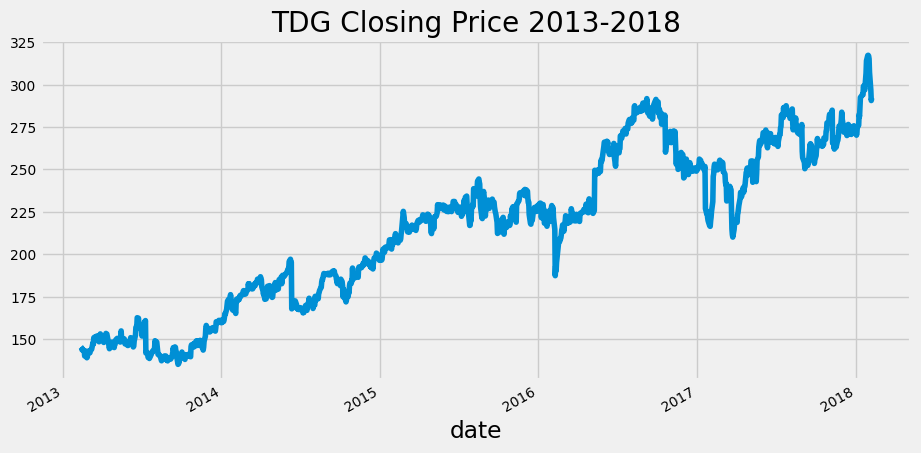

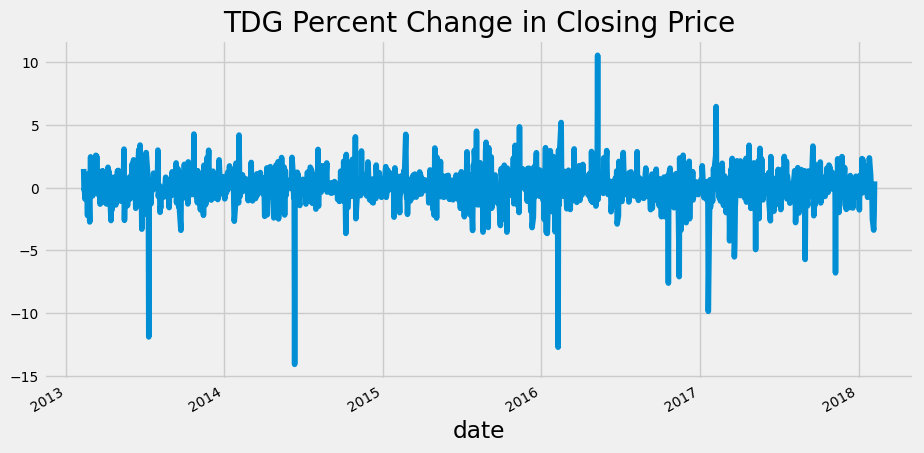

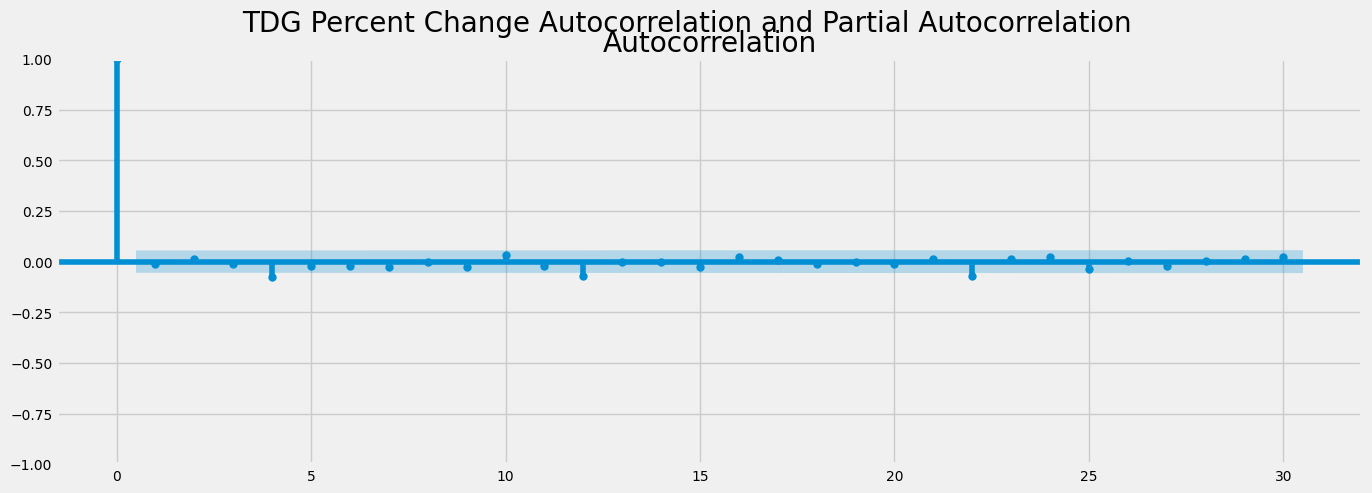

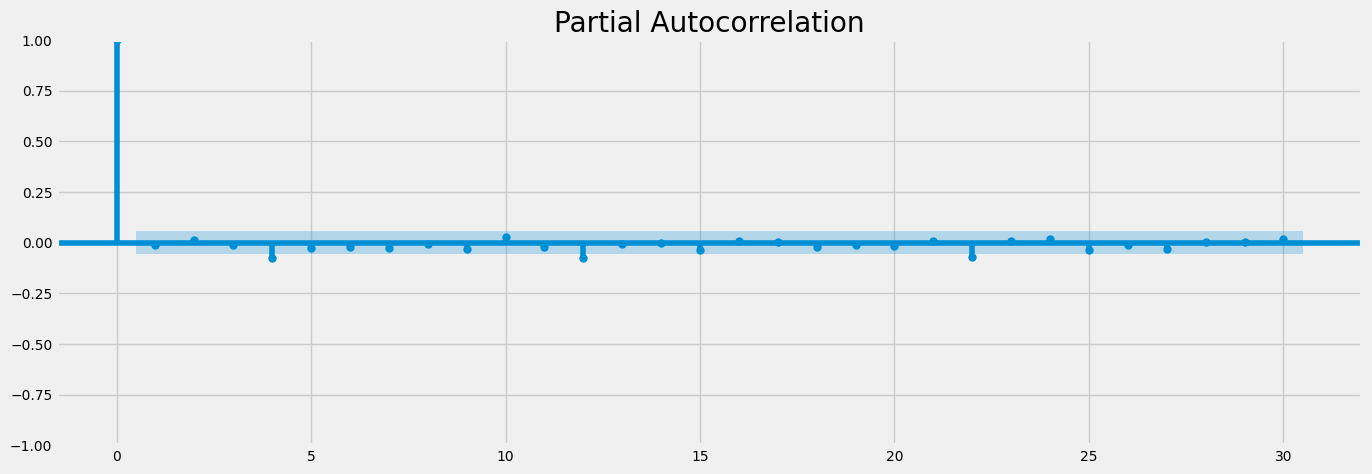

In [4]:
stock = 'TDG'
df = pd.read_csv(
    f"C:/Users/Acer/Downloads/S&P500StockData/individual_stocks_5yr/individual_stocks_5yr/{stock}_data.csv"
)
df.index = pd.DatetimeIndex(df.date)
df = df.drop(columns=['open', 'high', 'low', 'volume', 'date', 'Name'])
df['pct_change'] = 100*df['close'].pct_change()
df.dropna(inplace=True)
df['close'].plot(figsize=(10, 5), title=f'{stock} Closing Price 2013-2018')
plt.show()
df['pct_change'].plot(figsize=(10, 5), title=f'{stock} Percent Change in Closing Price')
plt.show()
acf = plot_acf(df['pct_change'], lags=30)
pacf = plot_pacf(df['pct_change'], lags=30)
acf.suptitle(f'{stock} Percent Change Autocorrelation and Partial Autocorrelation', fontsize=20)
acf.set_figheight(5)
acf.set_figwidth(15)
pacf.set_figheight(5)
pacf.set_figwidth(15)
plt.show()

Ljung-Box Test

Ljung-Box is a test for autocorrelation that we can use in tandem with our ACF and PACF plots. The Ljung-Box test takes our data, optionally either lag values to test, or the largest lag value to consider, and whether to compute the Box-Pierce statistic. Ljung-Box and Box-Pierce are two similar test statisitcs, Q, that are compared against a chi-squared distribution to determine if the series is white noise. We might use the Ljung-Box test on the residuals of our model to look for autocorrelation, ideally our residuals would be white noise.

Ho: The data are independently distributed, no autocorrelation.
Ha: The data are not independently distributed; they exhibit serial correlation.

The Ljung-Box with the Box-Pierce option will return, for each lag, the Ljung-Box test statistic, Ljung-Box p-values, Box-Pierce test statistic, and Box-Pierce p-values.

If p<α(0.05) we reject the null hypothesis.

In [6]:
ljung_res = acorr_ljungbox(df['pct_change'], lags=40, boxpierce=True)
print("Ljung-Box p-values:\n", ljung_res['lb_pvalue'])
print("\nBox-Pierce p-values:\n", ljung_res['bp_pvalue'])


Ljung-Box p-values:
 1     0.742543
2     0.878076
3     0.928541
4     0.103109
5     0.134174
6     0.166162
7     0.189601
8     0.265793
9     0.288524
10    0.275716
11    0.319872
12    0.093785
13    0.129779
14    0.172710
15    0.178878
16    0.198560
17    0.247452
18    0.291294
19    0.349644
20    0.400352
21    0.447816
22    0.182174
23    0.213494
24    0.226142
25    0.206709
26    0.247872
27    0.265572
28    0.310534
29    0.350615
30    0.363217
31    0.404475
32    0.452509
33    0.500322
34    0.208378
35    0.228744
36    0.260598
37    0.297138
38    0.335371
39    0.377598
40    0.421014
Name: lb_pvalue, dtype: float64

Box-Pierce p-values:
 1     0.742839
2     0.878401
3     0.928866
4     0.104593
5     0.136113
6     0.168589
7     0.192499
8     0.269373
9     0.292645
10    0.280350
11    0.325117
12    0.097500
13    0.134514
14    0.178497
15    0.185212
16    0.205642
17    0.255563
18    0.300288
19    0.359421
20    0.410750
21    0.458713
22    0.1

In [7]:
def ts_plot(residuals, stan_residuals, lags=50):
    residuals.plot(title='GARCH Residuals', figsize=(15, 10))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=20)
    acf.set_figheight(5)
    acf.set_figwidth(15)
    pacf.set_figheight(5)
    pacf.set_figwidth(15)
    plt.show()

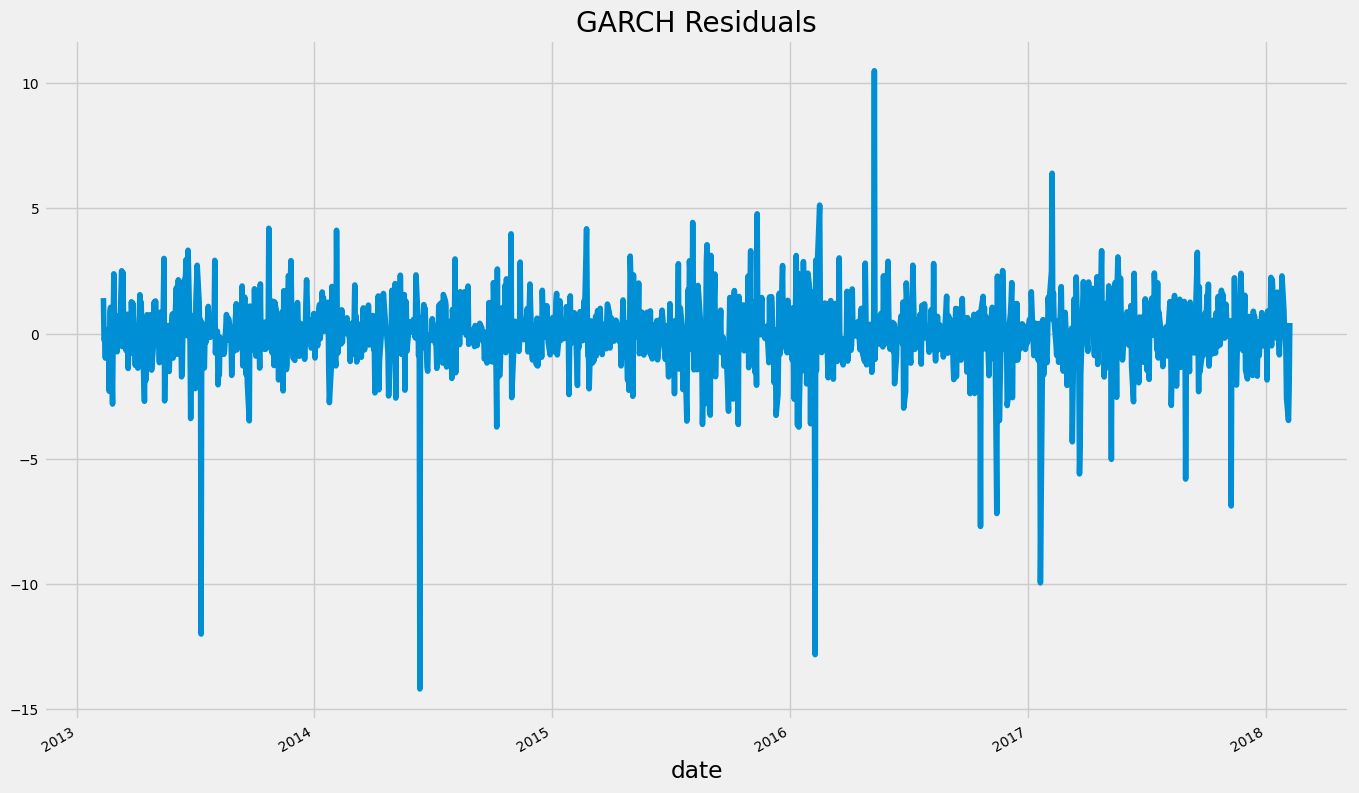

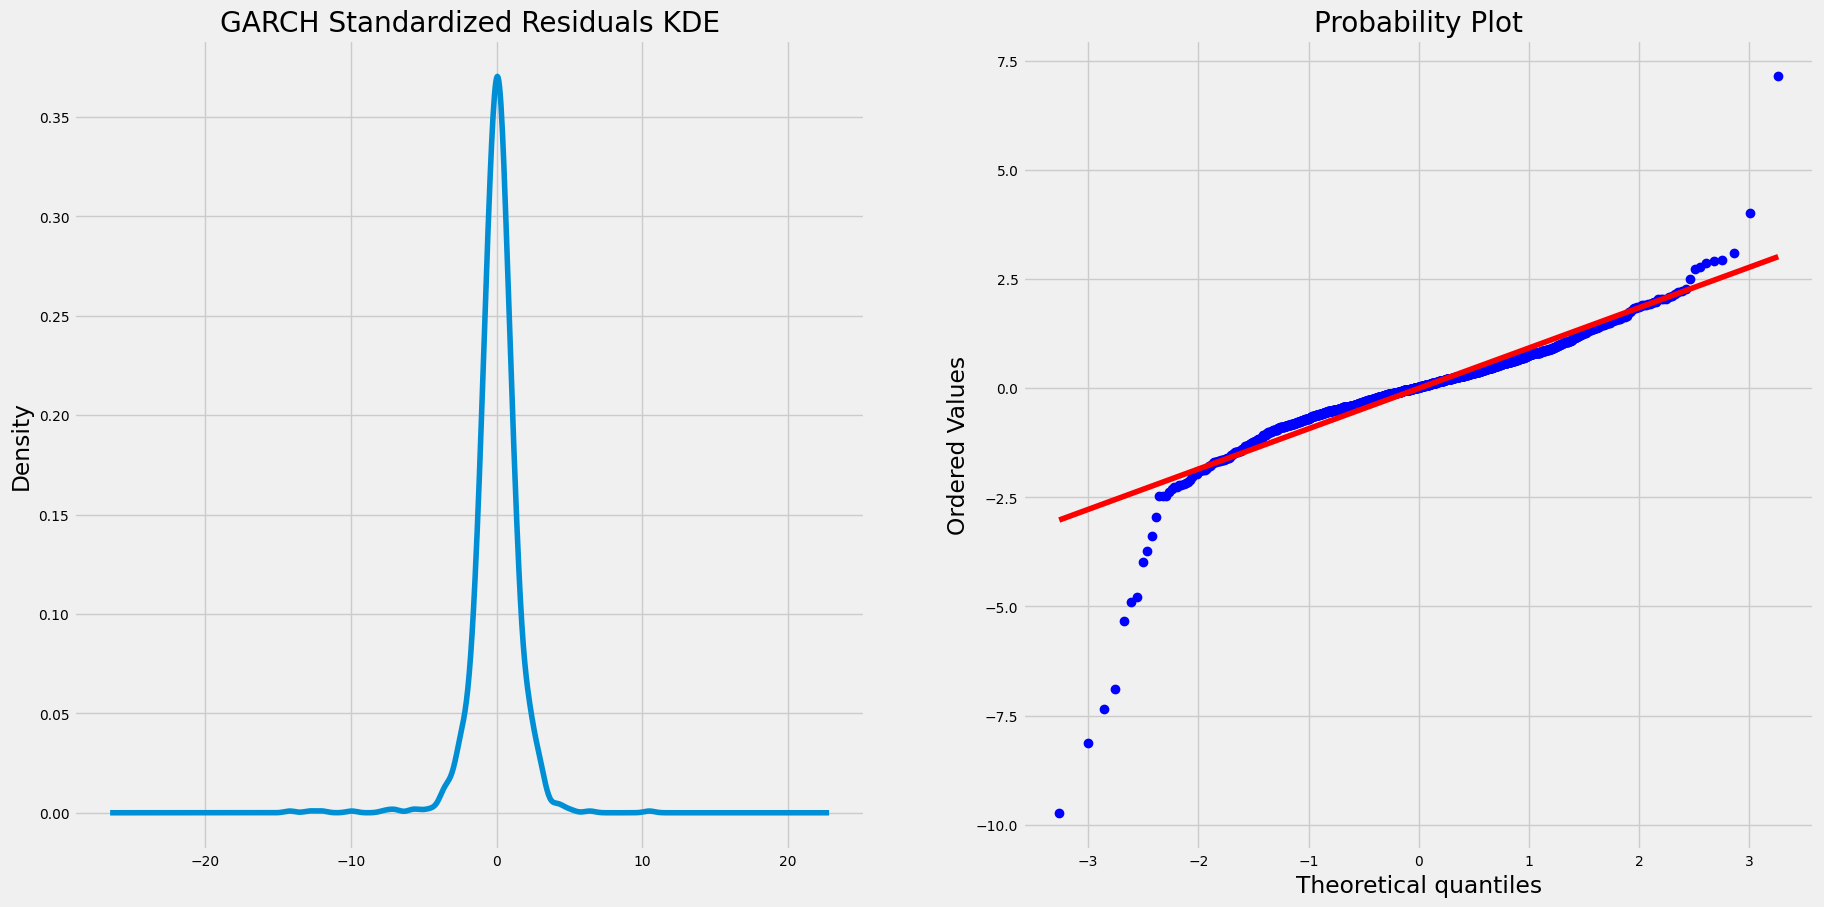

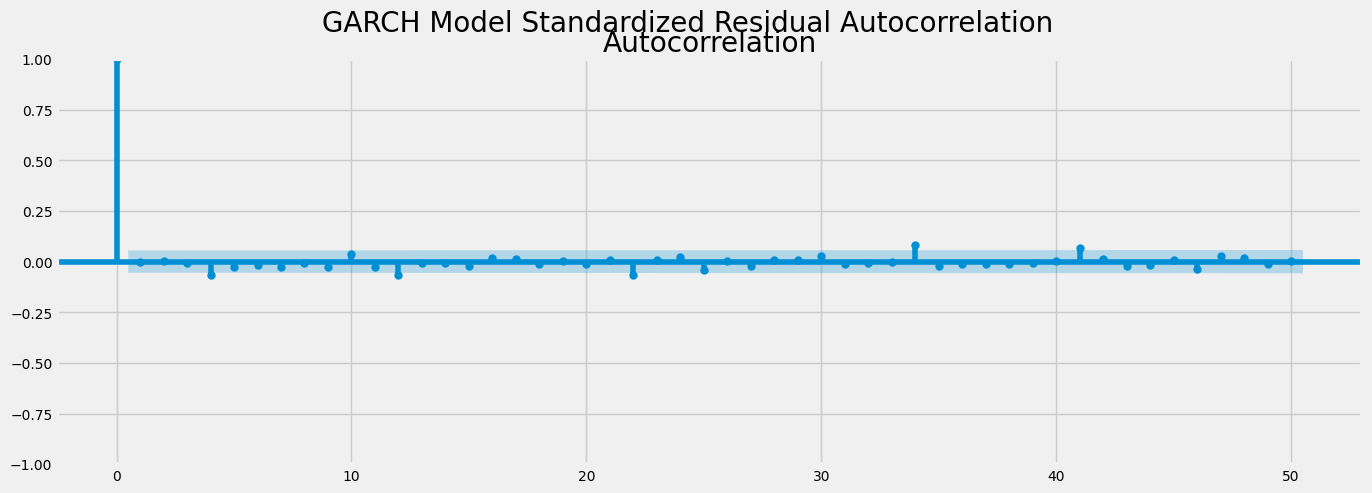

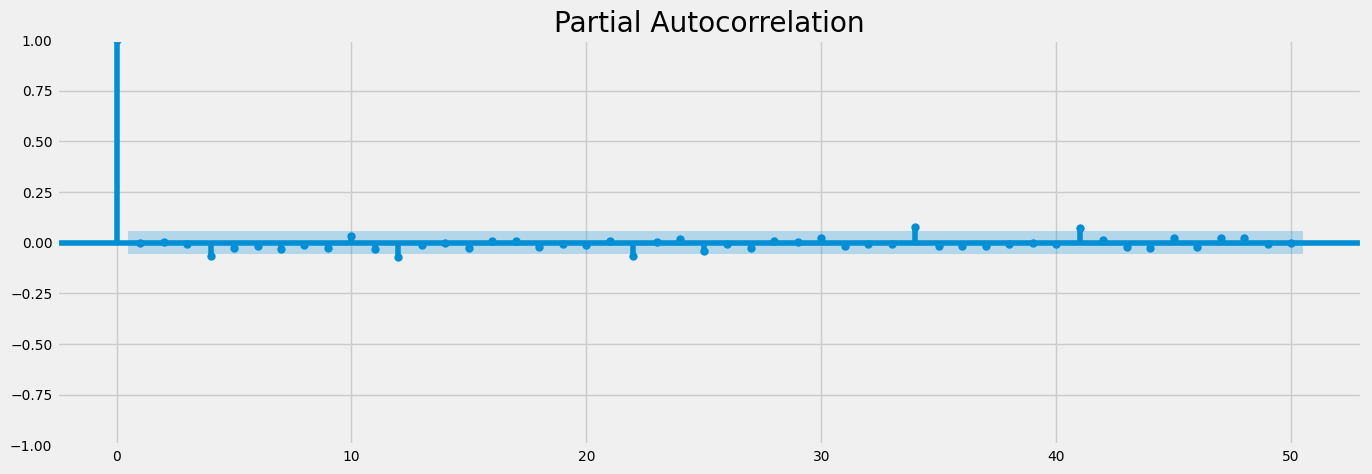

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2307.11
Distribution:                  Normal   AIC:                           4622.21
Method:            Maximum Likelihood   BIC:                           4642.76
                                        No. Observations:                 1258
Date:                Sat, Aug 16 2025   Df Residuals:                     1257
Time:                        09:49:37   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0755  4.505e-02      1.677  9.359e-02 [-1.276e-02,  0.164]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.9758      0.596      1.636      0.102    [ -0.193,  2.145]
alpha[1]       0.0632  9.635e-02      0.656      0.512    [ -0.126,  0.252]
beta[1]        0.5220      0.305      1.711  8.706e-02 [-7.592e-02,  1.120]
===========================================================================

Covariance estimator: robust
"""

In [8]:
garch = arch_model(df['pct_change'], vol='GARCH', p=1, q=1, dist='normal')
fgarch = garch.fit(disp='off') 
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)
fgarch.summary()


In [9]:
arch_test = het_arch(resid, maxlag=50)
shapiro_test = shapiro(st_resid)

print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')

C:\Users\Acer\AppData\Local\Temp\ipykernel_4176\622623102.py:1: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test = het_arch(resid, maxlag=50)


Lagrange mulitplier p-value: 0.9999999997772875
F test p-value: 0.9999999998466416
Shapiro-Wilks p-value: 1.8125675480558453e-32


GARCH Results

Here are the results of our GARCH(1,1) model:

Omega is the baseline variance for the model, so the square root of omega is the standard deviation of returns, 60%. This means that with our mean around 0 we can expect our returns to be 0 with a 60% standard deviation, which is very volatile. Autocorrelation in a model can dampen the volatility and cluster low volatility days but this model is capable of producing very large surges.

Next, our alpha and beta coefficients. Alpha measures the extent to which a volatility shock today feeds through into next period’s volatility. In our model 9% of the previous periods volatility will be passed to the next day. Beta is our persistence parameter, if beta is greater than 1 it leads to a postive feedback loop for small shocks that can create runaway volatility. The sum of alpha and beta measures the rate at which our volatility decays and if alpha plus beta equals 1 then our model has persistent volatility and we might want to look at other models like IGARCH (Integrated GARCH).

According the the text, Market Risk Analysis the usual range for alpha in a stable market is  0.05<α<0.1 and the parameter beta is  0.85<β<0.98. These ranges won't totally apply to forecasting a single stock but it gives us an idea of what kinds of values we should be seeing.

Next, we have our t-statistics and p-values. T is our estimate divided by the standard error and is used to calculate our p-value. The usual null hypothesis is that our coefficient has no effect but we can reject the null if our p value is less than an alpha (0.05). When we begin having models with more parameters it can be helpful to pay attention to the p-values.

Above we have run some test for goodness of fit that we'll introduce below. All of the tests indicate we should reject the null so we'll continue to search for better model parameters. We can see there is clearly autocorrelation out to at least the 25th lag, and the standardized residuals do not look like white noise. We'll use a gridsearch with fairly large range of p and q to find a model that best fits the volatility.

Model Fit

To measure how well our ARCH/GARCH model fit our data we want to check for:

1. Autocorrelation in the standardized residuals, we can again use the Ljung-Box test.
2. ARCH effects(conditional heteroskedasticity) in the residuals, we will use Engle's ARCH test on the residuals.
3. Normal distribution in the standardized residuals, we can use the Shapiro-Wilk test, Q-Q plot, and if larger n- the Jarque-Bera test to see if our data approaches normality. 

Engle's ARCH Test

Ho: The squared residuals are a sequence of white noise- the residuals are homoscedastic.
Ha: The squared residuals could not be fitted with a linear regression model and exhibit heteroskedasticity.

In python we will be using the ARCH Engle's test which is a combination of Ljung-Box and a Lagrange Multiplier test to determine if our ARCH model has captured the conditional heteroskedasticity of our time series. We will pass it the array of residuals and a max lag to use.


Shapiro-Wilks Test

The Shapiro-wilks test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution.

Ho: The data is normally distributed
Ha: The data is not normally distributed

Jarque-Bera Test

The Jarque-Bera test is a type of lagrange multiplier test for normality. It usually used for large data sets because other normality tests are not reliable when n is large, Shapiro-Wilk isn't reliable with n more than 2,000. Jarque-Bera specifically mathces skewness and kurtosis to a normal distribution.

Ho: The data is normally distributed
Ha: The data does not come from a normal distribution

In [10]:
def gridsearch(data, p_rng, q_rng):
    top_score, top_results = float('inf'), None
    top_models = []
    for p in p_rng:
        for q in q_rng:
            try:
                model = arch_model(data, vol='GARCH', p=p, q=q, dist='normal')
                model_fit = model.fit(disp='off')
                resid = model_fit.resid
                st_resid = np.divide(resid, model_fit.conditional_volatility)
                results = evaluate_model(resid, st_resid)
                results['AIC'] = model_fit.aic
                results['params']['p'] = p
                results['params']['q'] = q
                if results['AIC'] < top_score: 
                    top_score = results['AIC']
                    top_results = results
                elif results['LM_pvalue'][1] is False:
                    top_models.append(results)
            except:
                continue
    top_models.append(top_results)
    return top_models
                
def evaluate_model(residuals, st_residuals, lags=50):
    results = {
        'LM_pvalue': None,
        'F_pvalue': None,
        'SW_pvalue': None,
        'AIC': None,
        'params': {'p': None, 'q': None}
    }
    arch_test = het_arch(residuals, maxlag=lags)
    shap_test = shapiro(st_residuals)
    # We want falsey values for each of these hypothesis tests
    results['LM_pvalue'] = [arch_test[1], arch_test[1] < .05]
    results['F_pvalue'] = [arch_test[3], arch_test[3] < .05]
    results['SW_pvalue'] = [shap_test[1], shap_test[1] < .05]
    return results

In [11]:
p_rng = range(0,30)
q_rng = range(0,40)
df['dif_pct_change'] = df['pct_change'].diff()
top_models = gridsearch(df['dif_pct_change'], p_rng, q_rng)
print(top_models)

[None]


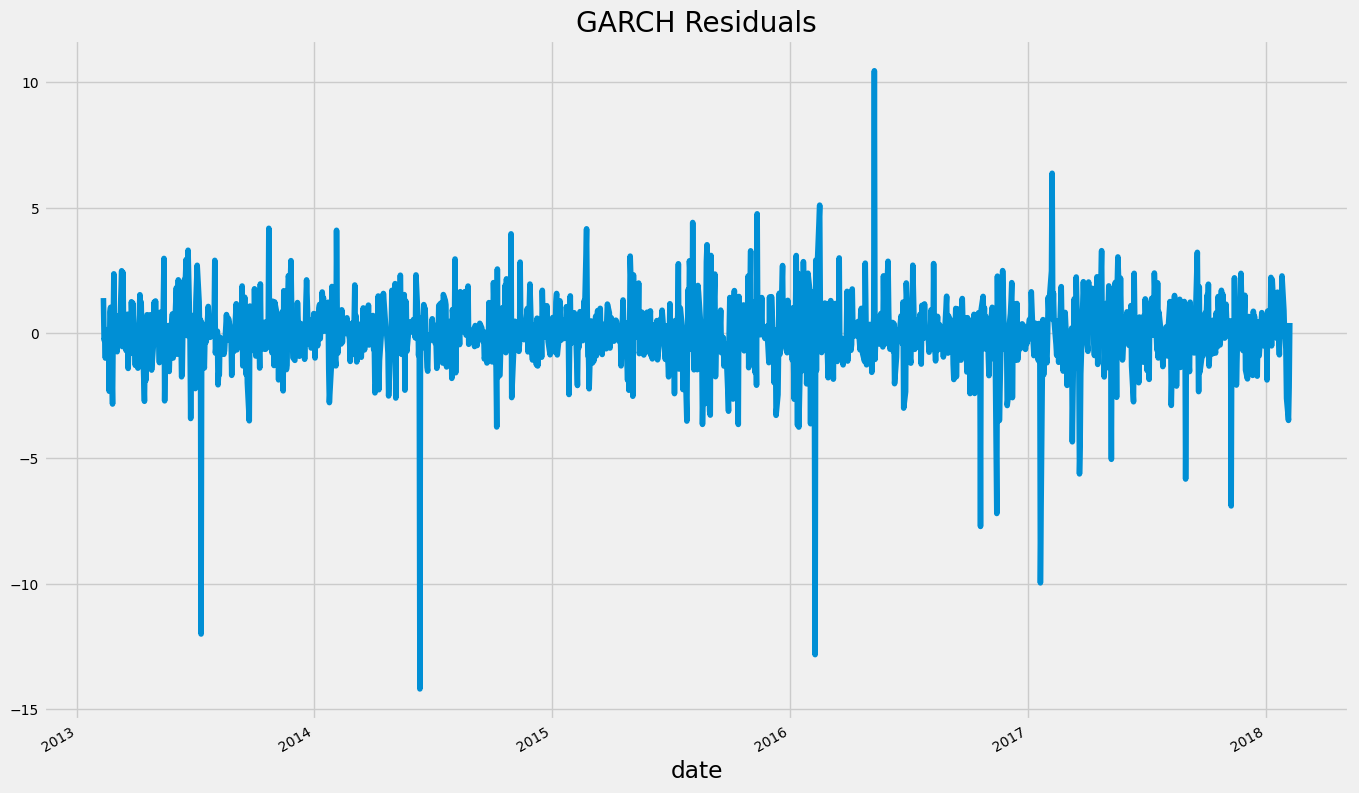

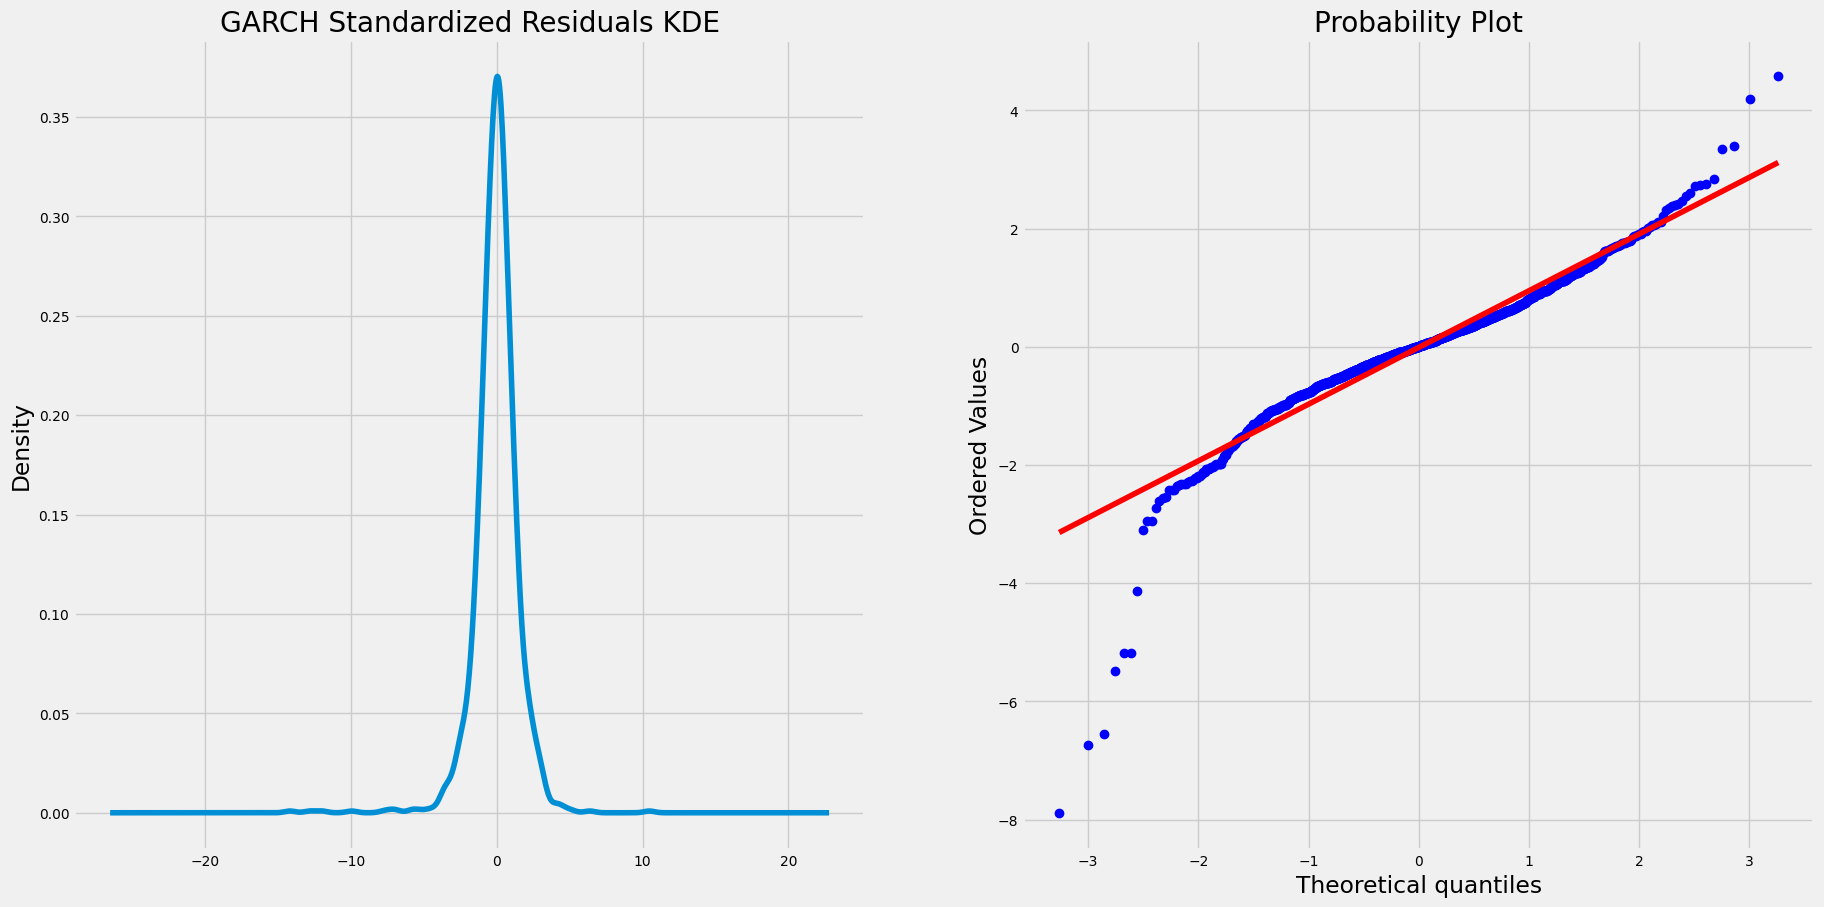

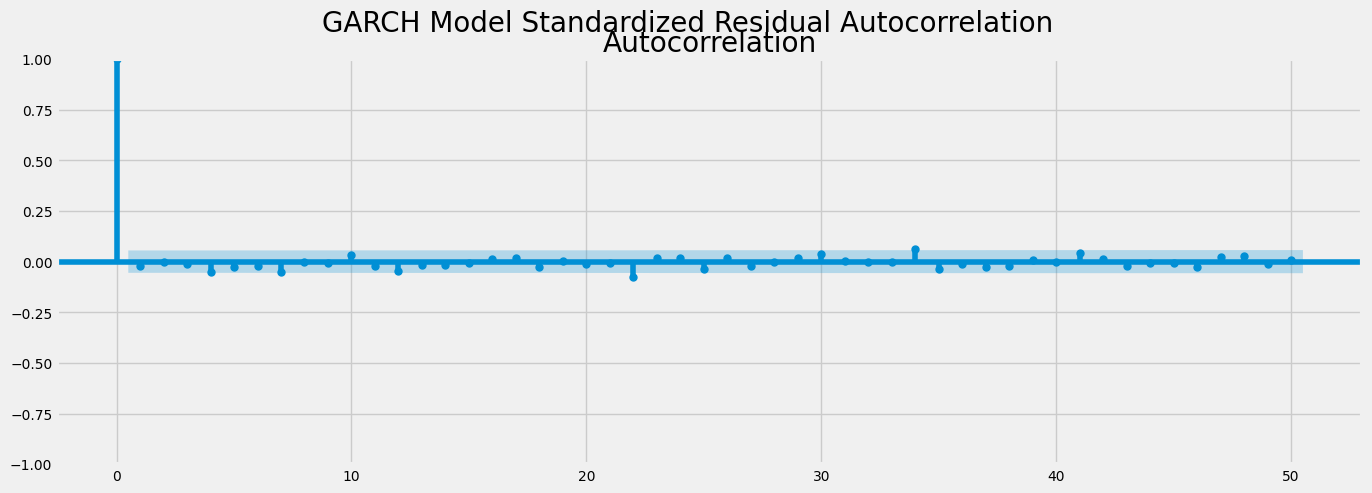

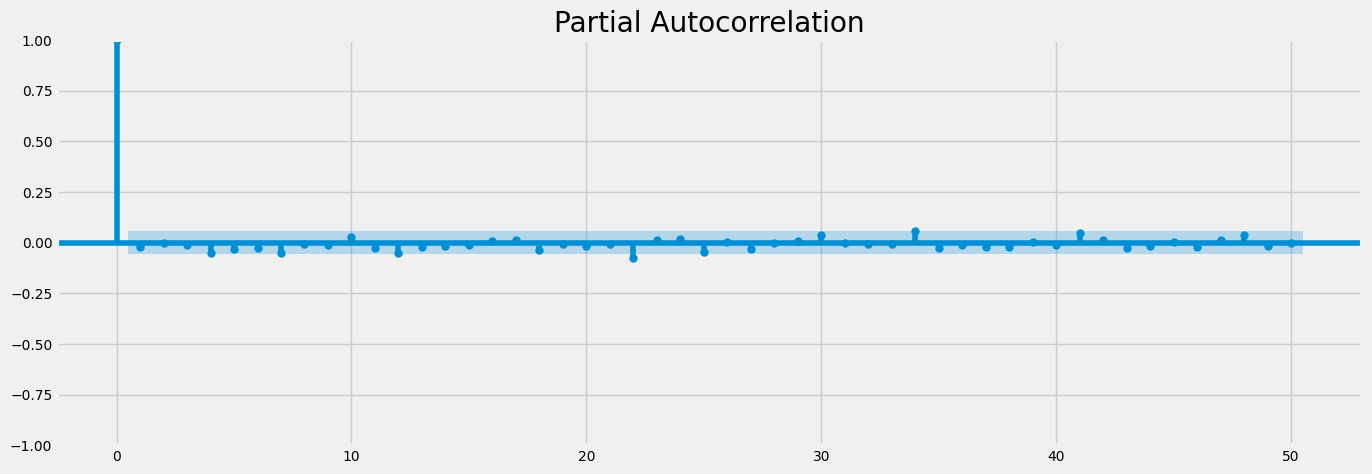

C:\Users\Acer\AppData\Local\Temp\ipykernel_4176\3993344148.py:6: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test = het_arch(resid, maxlag=50)


Lagrange mulitplier p-value: 0.9999999997882277
F test p-value: 0.9999999998542379
Shapiro-Wilks p-value: 1.54871529853152e-25


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             pct_change   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2242.06
Distribution:                  Normal   AIC:                           4572.12
Method:            Maximum Likelihood   BIC:                           4798.16
                                        No. Observations:                 1258
Date:                Sat, Aug 16 2025   Df Residuals:                     1257
Time:                        09:59:05   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0998  5.392e-02      1.850  6.429e-02 [-5.920e-03,  0.205]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.4146      0.319      1.301      0.193      [ -0.210,  1.039]
alpha[1]   1.5813e-04  7.474e-02  2.116e-03      0.998      [ -0.146,  0.147]
alpha[2]   9.3507e-12      0.214  4.366e-11      1.000      [ -0.420,  0.420]
alpha[3]   1.9272e-11  5.060e-02  3.808e-10      1.000 [-9.918e-02,9.918e-02]
alpha[4]       0.1026      0.173      0.594      0.553      [ -0.236,  0.442]
alpha[5]   2.7824e-11  3.149e-02  8.836e-10      1.000 [-6.172e-02,6.172e-02]
alpha[6]   2.4963e-11  3.396e-02  7.350e-10      1.000 [-6.656e-02,6.656e-02]
alpha[7]   4.5982e-03  4.306e-02      0.107      0.915 [-7.980e-02,8.899e-02]
alpha[8]   1.8250e-11  3.225e-02  5.660e-10      1.000 [-6.320e-02,6.320e-02]
alpha[9]   1.9942e-11  1.217e-02  1.639e-09      1.000 [-2.385e-02,2.385e-02]
alpha[10]  2.9311e-11      0.104  2.824e-10      1.000      [ -0.203,  0.203]
alpha[11]  2.7257e-03  7.326e-02  3.721e-02      0.970      [ -0.141,  0.146]
alpha[12]      0.0360      0.170      0.212      0.832      [ -0.297,  0.369]
alpha[13]  2.8575e-11  5.734e-02  4.984e-10      1.000      [ -0.112,  0.112]
alpha[14]  3.8242e-11  5.625e-02  6.799e-10      1.000      [ -0.110,  0.110]
alpha[15]  1.2050e-09  1.700e-02  7.087e-08      1.000 [-3.332e-02,3.332e-02]
alpha[16]      0.2678      0.126      2.124  3.370e-02    [2.064e-02,  0.515]
alpha[17]      0.0271      0.117      0.232      0.817      [ -0.203,  0.257]
beta[1]    8.3312e-12      0.171  4.883e-11      1.000      [ -0.334,  0.334]
beta[2]    1.7901e-11      0.368  4.869e-11      1.000      [ -0.721,  0.721]
beta[3]    9.0410e-12      0.187  4.831e-11      1.000      [ -0.367,  0.367]
beta[4]    8.3833e-03      0.250  3.357e-02      0.973      [ -0.481,  0.498]
beta[5]    1.1113e-11      0.168  6.605e-11      1.000      [ -0.330,  0.330]
beta[6]    1.3281e-11      0.428  3.106e-11      1.000      [ -0.838,  0.838]
beta[7]    1.8640e-12      0.462  4.039e-12      1.000      [ -0.905,  0.905]
beta[8]    5.8790e-12      0.121  4.874e-11      1.000      [ -0.236,  0.236]
beta[9]    1.7968e-11      0.218  8.245e-11      1.000      [ -0.427,  0.427]
beta[10]   2.3737e-08      0.491  4.834e-08      1.000      [ -0.963,  0.963]
beta[11]   4.5769e-12      0.289  1.585e-11      1.000      [ -0.566,  0.566]
beta[12]   8.1474e-12      0.112  7.301e-11      1.000      [ -0.219,  0.219]
beta[13]   3.7066e-12      0.204  1.813e-11      1.000      [ -0.401,  0.401]
beta[14]   1.4825e-11      0.119  1.247e-10      1.0

In [12]:
garch = arch_model(df['pct_change'], vol='GARCH', p=17, q=25, dist='normal')
fgarch = garch.fit(disp='off') 
resid = fgarch.resid
st_resid = np.divide(resid, fgarch.conditional_volatility)
ts_plot(resid, st_resid)
arch_test = het_arch(resid, maxlag=50)
shapiro_test = shapiro(st_resid)
print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')
print(f'Shapiro-Wilks p-value: {shapiro_test[1]}')
fgarch.summary()

Conclusion

With parameters GARCH(17, 25) we have a model that passed our Engel ARCH test and whose standardized residuals appear approximately normal. Looking at the residuals and our correlograms this model does not have residuals that appear to be white noise and both the PACF and ACF seem to have a significant coefficient at lag ~22, so we didn't satisfactorily model the conditional variance. Capturing the volatility of a single stock can be very difficult.

The benefit of this is that it is easy to rerun with a different stock. The first cell shows 8 random stocks and some will certainly be easier to model than others. 'TDG' seemed like a very volatile stock with a few very large dips that clearly persist in the residuals of our final model. If you use this to model another stock it would probably be better to choose one with less volatility and trend.